In [32]:
import numpy as np                                                                                                                                                                                  
import xarray as xr                                                                                                                                                                                 
import os                                                                                                                                                                                           
import matplotlib.pyplot as plt                                                                                                                                                                     
import matplotlib.cm as cm    
import matplotlib.pyplot as plt
import numpy as np                                                                                                                                                                                  
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.reset_defaults()
sns.set_context("talk", font_scale=0.8)
import warnings
warnings.filterwarnings('ignore')
from myfuncts2  import *
%load_ext autoreload
%autoreload 2
from scipy.ndimage import gaussian_filter1d
                                                                                                                                                                                                    
  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from mpsd import *
from myfuncts2  import *

L4 = xr.open_mfdataset('data/cords/l4.nc')


sst="analysed_sst"
#L4 = L4.sel(time=slice(L4['time'][0],L4['time'][273]))

alldata=sorted(list(L4.keys()))
for i in alldata:
    #i='eNATL_'+i
    print(i)
    signal= L4[i].chunk({"lat":1, 'time': L4['time'].size, 'lon': L4['lon'].size})
    signal['time'] = (signal.time - signal.time[0]) / numpy.timedelta64(1, 'D')
    psd_signal = xrft.power_spectrum(signal, dim=['time','lon'], detrend='constant', window=True).compute()
    mean_psd_signal = psd_signal.mean(dim=['lat']).where( (psd_signal.freq_time > 0) &(psd_signal.freq_lon > 0), drop=True)

    mean_psd_signal_lon = mean_psd_signal.mean("freq_time")
    mean_psd_signal_lon=mean_psd_signal_lon.rename({'freq_lon': 'freq_lon_'+i})
    L4=L4.assign(psd=mean_psd_signal_lon)
    L4=L4.rename({'psd': 'psd_'+i})
model = xr.open_mfdataset('data/daily/enatl_nn.nc')


analysed_sst
analysis_error


# Def filter

In [34]:
def create_filter(xx):
    

    ds_cor=xr.open_dataset('data/cords/coordinates.nc')
    ds_mask=xr.open_dataset('data/cords/masks.nc')
    ### ds
    gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)
    ### grid info centered at T-points
    wet_mask = ds_mask.tmask[0,0,:,:]
    dxT = ds_cor.e1t
    dyT = ds_cor.e2t
    area = dxT * dyT
    ### grid info centered at U-points
    dxw = ds_cor.e1u
    dyw = ds_cor.e2u
    ### grid info centered at V-points
    dxs = ds_cor.e1v
    dys = ds_cor.e2v
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    dx_min
    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    filter_scale = xx

    filter_xxkm = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': wet_mask, 
            'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
            'kappa_w': kappa_w, 'kappa_s': 0.01*kappa_s
        }
    )
    
    return filter_xxkm


In [35]:
filter25km =create_filter(50000)


# Noise/gcm cooking

In [36]:
eNATL=xr.open_dataset('data/cords/eNATL.nc')
a=eNATL['sosstsst'].min().values
b=eNATL['sosstsst'].max().values
eNATL=eNATL.assign(blank=0*eNATL['sosstsst'])


In [37]:
filter25km =create_filter(6400)
pr=0.6
eNATL=eNATL.assign(noise=eNATL['blank']+np.random.uniform(low=-b*pr/100, high=b*pr/100, size=eNATL['blank'].shape))
eNATL=eNATL.assign(enatl_noise_gcm2=eNATL['sosstsst']+filter25km.apply(eNATL['noise'], dims=['lat', 'lon']))

for i in range(10):
    pr=0.60
    eNATL=eNATL.assign(enatl_noise_gcm2=eNATL['enatl_noise_gcm2']+np.random.uniform(low=-b*pr/100, high=b*pr/100, size=eNATL['blank'].shape))
    filter25km =create_filter(6400)
    eNATL=eNATL.assign(enatl_noise_gcm2=filter25km.apply(eNATL['enatl_noise_gcm2'], dims=['lat', 'lon']))


In [38]:
filter25km =create_filter(22000)
pr=3
eNATL=eNATL.assign(noise=eNATL['blank']+np.random.uniform(low=-b*pr/100, high=b*pr/100, size=eNATL['blank'].shape))
eNATL=eNATL.assign(enatl_noise_gcm=eNATL['sosstsst']+filter25km.apply(eNATL['noise'], dims=['lat', 'lon']))

pr=0.60
eNATL=eNATL.assign(enatl_noise_gcm=eNATL['enatl_noise_gcm']+np.random.uniform(low=-b*pr/100, high=b*pr/100, size=eNATL['blank'].shape))
filter25km =create_filter(6400)
eNATL=eNATL.assign(enatl_noise_gcm=filter25km.apply(eNATL['enatl_noise_gcm'], dims=['lat', 'lon']))

pr=0.60
eNATL=eNATL.assign(enatl_noise_gcm=eNATL['enatl_noise_gcm']+np.random.uniform(low=-b*pr/100, high=b*pr/100, size=eNATL['blank'].shape))
filter25km =create_filter(6400)
eNATL=eNATL.assign(enatl_noise_gcm=filter25km.apply(eNATL['enatl_noise_gcm'], dims=['lat', 'lon']))
pr=0.60
eNATL=eNATL.assign(enatl_noise_gcm=eNATL['enatl_noise_gcm']+np.random.uniform(low=-b*pr/100, high=b*pr/100, size=eNATL['blank'].shape))
filter25km =create_filter(6400)
eNATL=eNATL.assign(enatl_noise_gcm=filter25km.apply(eNATL['enatl_noise_gcm'], dims=['lat', 'lon']))



pr=0.60
eNATL=eNATL.assign(enatl_noise_gcm=eNATL['enatl_noise_gcm']+np.random.uniform(low=-b*pr/100, high=b*pr/100, size=eNATL['blank'].shape))
filter25km =create_filter(6400)
eNATL=eNATL.assign(enatl_noise_gcm=filter25km.apply(eNATL['enatl_noise_gcm'], dims=['lat', 'lon']))
pr=0.60
eNATL=eNATL.assign(enatl_noise_gcm=eNATL['enatl_noise_gcm']+np.random.uniform(low=-b*pr/100, high=b*pr/100, size=eNATL['blank'].shape))
filter25km =create_filter(6400)
eNATL=eNATL.assign(enatl_noise_gcm=filter25km.apply(eNATL['enatl_noise_gcm'], dims=['lat', 'lon']))
pr=0.60
eNATL=eNATL.assign(enatl_noise_gcm=eNATL['enatl_noise_gcm']+np.random.uniform(low=-b*pr/100, high=b*pr/100, size=eNATL['blank'].shape))
filter25km =create_filter(6400)
eNATL=eNATL.assign(enatl_noise_gcm=filter25km.apply(eNATL['enatl_noise_gcm'], dims=['lat', 'lon']))


# pr=0.60
# eNATL=eNATL.assign(enatl_noise_gcm=eNATL['enatl_noise_gcm']+np.random.uniform(low=-b*pr/100, high=b*pr/100, size=eNATL['blank'].shape))
# filter25km =create_filter(6400)
# eNATL=eNATL.assign(enatl_noise_gcm=filter25km.apply(eNATL['enatl_noise_gcm'], dims=['lat', 'lon']))
# pr=0.60
# eNATL=eNATL.assign(enatl_noise_gcm=eNATL['enatl_noise_gcm']+np.random.uniform(low=-b*pr/100, high=b*pr/100, size=eNATL['blank'].shape))
# filter25km =create_filter(6400)
# eNATL=eNATL.assign(enatl_noise_gcm=filter25km.apply(eNATL['enatl_noise_gcm'], dims=['lat', 'lon']))


In [39]:
alldata=['noise', 'enatl_noise_gcm', 'blank', 'sosstsst','enatl_noise_gcm2']
for i in alldata:
    signal= eNATL[i].chunk({"lat":1, 'time': eNATL['time'].size, 'lon': eNATL['lon'].size})
    signal['time'] = (signal.time - signal.time[0]) / numpy.timedelta64(1, 'D')
    psd_signal = xrft.power_spectrum(signal, dim=['time','lon'], detrend='constant', window=True).compute()
    mean_psd_signal = psd_signal.mean(dim=['lat']).where( (psd_signal.freq_time > 0) &(psd_signal.freq_lon > 0), drop=True)

    mean_psd_signal_lon = mean_psd_signal.mean("freq_time")
    mean_psd_signal_lon=mean_psd_signal_lon.rename({'freq_lon': 'freq_lon_'+i})
    eNATL=eNATL.assign(psd=mean_psd_signal_lon)
    eNATL=eNATL.rename({'psd': 'psd_'+i})

psd_analysed_sst
psd_enatl_noise_gcm
psd_sosstsst


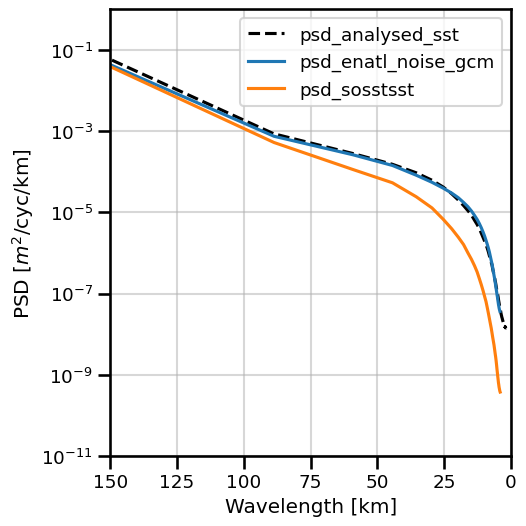

In [47]:


plt.rcParams["figure.figsize"] = [5.50, 5.50]


f, (ax1) = plt.subplots(1,1, sharey=True)


tocheck=['psd_analysed_sst']#, 'psd_analysis_error']



for i in tocheck:
    print(i)

    mini1=np.where(L4[i]==L4[i].values.min())[0][0]
    ax1.plot(1/L4[i]['freq_lon'+i[3:]][0:mini1]*111,L4[i][0:mini1], 'k--',label=i)

i=0

tocheck=['psd_enatl_noise_gcm', 'psd_sosstsst']

for i in tocheck:
    print(i)

    mini1=np.where(eNATL[i]==eNATL[i].values.min())[0][0]
    ax1.plot(1/eNATL[i]['freq_lon'+i[3:]][0:mini1]*111,eNATL[i][0:mini1], label=i)

i='psd_eNATL_sst'

#ax1.plot(1/model[i]['freq_lon'+i[3:]][:]*111,np.abs(-yinterp+model['psd_eNATL_sst'].values), label='Target (L4 - eNATL)')
#ax1.plot(1/model[i]['freq_lon'+i[3:]][:]*111,yinterp, 'k--',label='Target (L4)')


ax1.set_ylabel('PSD [$m^2$/cyc/km]')
ax1.set_xlabel('Wavelength [km]')
ax1.grid(which="both", alpha=0.5)  
ax1.legend()
ax1.set_yscale('log')
ax1.set_xlim([0, 150])
ax1.invert_xaxis()
ymin, ymax = ax1.get_ylim()
ax1.set_ylim([0.00000000001, 1])

plt.tight_layout()
plt.show()    


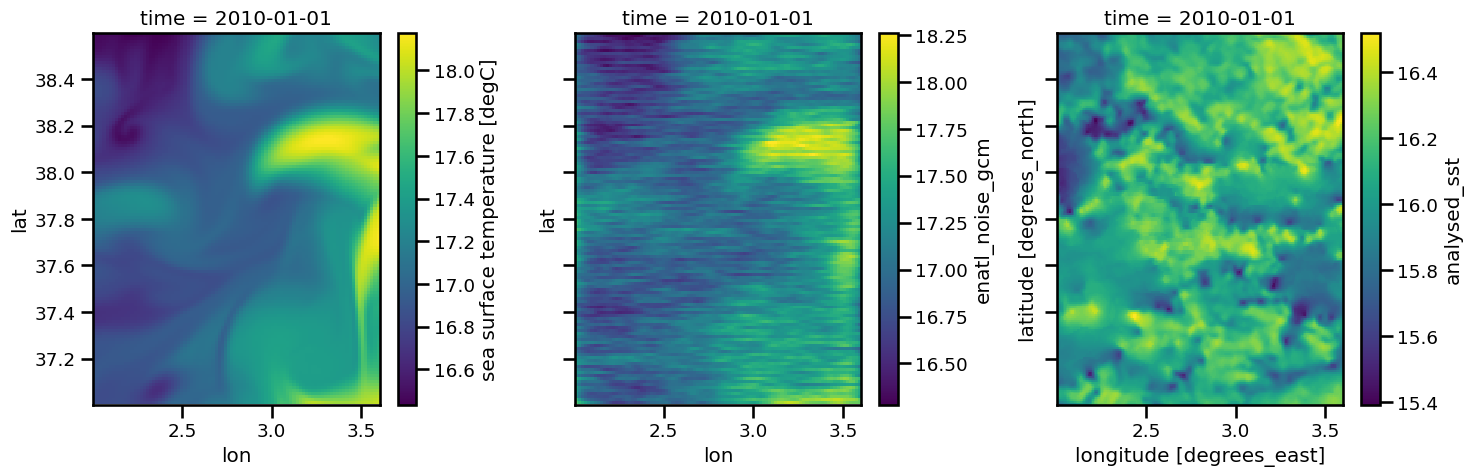

In [48]:
plt.rcParams["figure.figsize"] = [15, 5]
f, ax = plt.subplots(1, 3, sharey=True)

eNATL['sosstsst'][0,:,:].plot(ax=ax[0],x='lon', y='lat')
eNATL['enatl_noise_gcm'][0,:,:].plot(ax=ax[1],x='lon', y='lat')
#eNATL['enatl_noise_gcm2'][0,:,:].plot(ax=ax[2],x='lon', y='lat')
L4['analysed_sst'][0,:,:].plot(ax=ax[2],x='lon', y='lat')
plt.tight_layout()
plt.show()

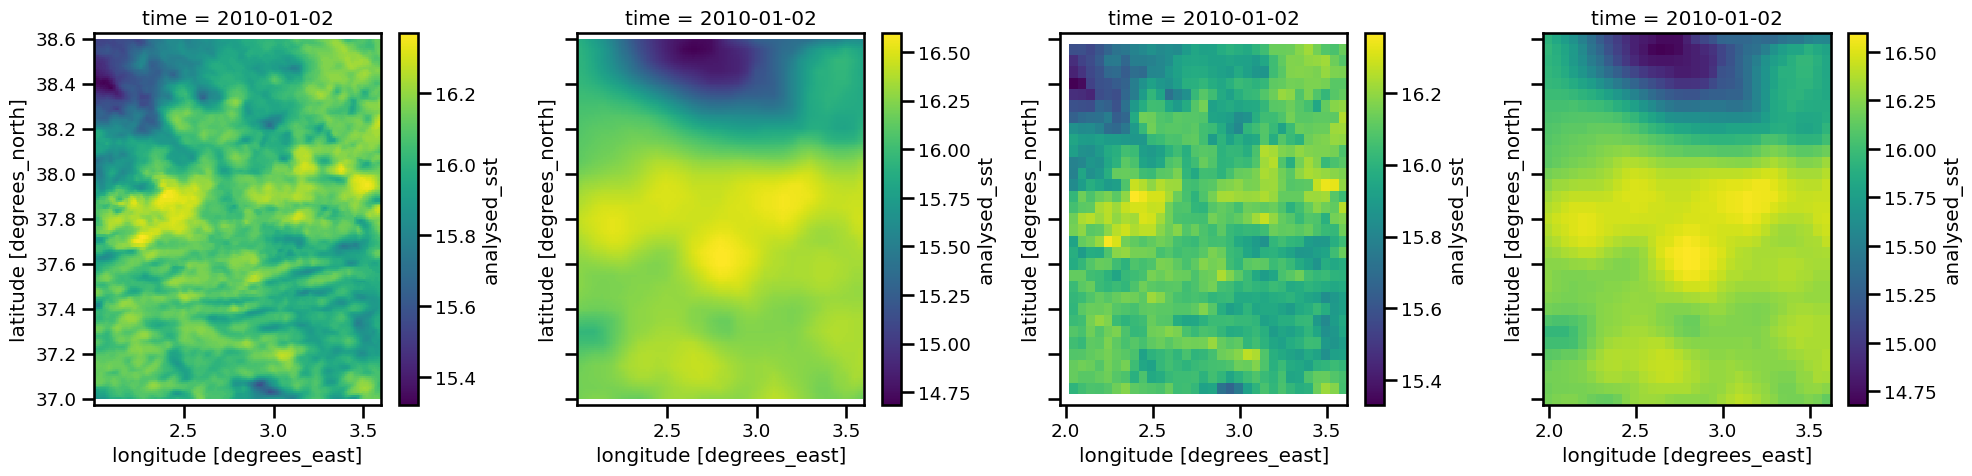

In [42]:
L4=xr.open_dataset('data/cords/l4.nc')
L405=xr.open_dataset('data/cords/l4_05.nc')
L401=xr.open_dataset('data/cords/l4_01.nc')
L405['analysed_sst']=L405['analysed_sst']-273.15
L405_interp = L405.interp(lat=L4.lat, lon=L4.lon)
L4_interp =L4.interp(lat=L405.lat, lon=L405.lon)
i=1
plt.rcParams["figure.figsize"] = [20, 5]
f, ax = plt.subplots(1, 4, sharey=True)

L4['analysed_sst'][i,:,:].plot(ax=ax[0],x='lon', y='lat')
L405_interp['analysed_sst'][i,:,:].plot(ax=ax[1],x='lon', y='lat')
L4_interp['analysed_sst'][i,:,:].plot(ax=ax[2],x='lon', y='lat')
L405['analysed_sst'][i,:,:].plot(ax=ax[3],x='lon', y='lat')

diff01=L405_interp-L4
diff05=L405-L4_interp

L405_interp['analysed_sst'] = L405_interp['analysed_sst'].fillna(0)
L4_interp['analysed_sst'] = L4_interp['analysed_sst'].fillna(0)


diff05['analysed_sst'] = diff05['analysed_sst'].fillna(0)
diff01['analysed_sst'] = diff01['analysed_sst'].fillna(0)

plt.tight_layout()
plt.show()

In [43]:
diff01

<xarray.Dataset>
Dimensions:         (time: 273, lat: 192, lon: 192)
Coordinates:
  * time            (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-09-30
  * lat             (lat) float32 37.0 37.01 37.02 37.03 ... 38.58 38.59 38.6
  * lon             (lon) float32 2.004 2.013 2.021 2.029 ... 3.579 3.588 3.596
Data variables:
    analysis_error  (time, lat, lon) float32 0.02 0.02 0.02 ... -0.01 -0.01 nan
    analysed_sst    (time, lat, lon) float32 0.2391 0.2279 ... 0.08703 0.0

In [44]:
from mpsd import *
from myfuncts2  import *


sst="analysed_sst"
#L4 = L4.sel(time=slice(L4['time'][0],L4['time'][273]))

alldata=sorted(list(L4.keys()))
for i in alldata:
    #i='eNATL_'+i
    print(i)
    signal= L4[i].chunk({"lat":1, 'time': L4['time'].size, 'lon': L4['lon'].size})
    signal['time'] = (signal.time - signal.time[0]) / numpy.timedelta64(1, 'D')
    psd_signal = xrft.power_spectrum(signal, dim=['time','lon'], detrend='constant', window=True).compute()
    mean_psd_signal = psd_signal.mean(dim=['lat']).where( (psd_signal.freq_time > 0) &(psd_signal.freq_lon > 0), drop=True)

    mean_psd_signal_lon = mean_psd_signal.mean("freq_time")
    mean_psd_signal_lon=mean_psd_signal_lon.rename({'freq_lon': 'freq_lon_'+i})
    L4=L4.assign(psd=mean_psd_signal_lon)
    L4=L4.rename({'psd': 'psd_'+i})

    

alldata=sorted(list(L405.keys()))
for i in alldata:
    #i='eNATL_'+i
    print(i)
    signal= L405[i].chunk({"lat":1, 'time': L405['time'].size, 'lon': L405['lon'].size})
    signal['time'] = (signal.time - signal.time[0]) / numpy.timedelta64(1, 'D')
    psd_signal = xrft.power_spectrum(signal, dim=['time','lon'], detrend='constant', window=True).compute()
    mean_psd_signal = psd_signal.mean(dim=['lat']).where( (psd_signal.freq_time > 0) &(psd_signal.freq_lon > 0), drop=True)

    mean_psd_signal_lon = mean_psd_signal.mean("freq_time")
    mean_psd_signal_lon=mean_psd_signal_lon.rename({'freq_lon': 'freq_lon_'+i})
    L405=L405.assign(psd=mean_psd_signal_lon)
    L405=L405.rename({'psd': 'psd_'+i})
    

    

alldata=sorted(list(L405_interp.keys()))
for i in alldata:
    #i='eNATL_'+i
    print(i)
    signal= L405_interp[i].chunk({"lat":1, 'time': L405_interp['time'].size, 'lon': L405_interp['lon'].size})
    signal['time'] = (signal.time - signal.time[0]) / numpy.timedelta64(1, 'D')
    psd_signal = xrft.power_spectrum(signal, dim=['time','lon'], detrend='constant', window=True).compute()
    mean_psd_signal = psd_signal.mean(dim=['lat']).where( (psd_signal.freq_time > 0) &(psd_signal.freq_lon > 0), drop=True)

    mean_psd_signal_lon = mean_psd_signal.mean("freq_time")
    mean_psd_signal_lon=mean_psd_signal_lon.rename({'freq_lon': 'freq_lon_'+i})
    L405_interp=L405_interp.assign(psd=mean_psd_signal_lon)
    L405_interp=L405_interp.rename({'psd': 'psd_'+i})


    

alldata=sorted(list(L4_interp.keys()))
for i in alldata:
    #i='eNATL_'+i
    print(i)
    signal= L4_interp[i].chunk({"lat":1, 'time': L4_interp['time'].size, 'lon': L4_interp['lon'].size})
    signal['time'] = (signal.time - signal.time[0]) / numpy.timedelta64(1, 'D')
    psd_signal = xrft.power_spectrum(signal, dim=['time','lon'], detrend='constant', window=True).compute()
    mean_psd_signal = psd_signal.mean(dim=['lat']).where( (psd_signal.freq_time > 0) &(psd_signal.freq_lon > 0), drop=True)

    mean_psd_signal_lon = mean_psd_signal.mean("freq_time")
    mean_psd_signal_lon=mean_psd_signal_lon.rename({'freq_lon': 'freq_lon_'+i})
    L4_interp=L4_interp.assign(psd=mean_psd_signal_lon)
    L4_interp=L4_interp.rename({'psd': 'psd_'+i})

    
    
    

alldata=sorted(list(diff01.keys()))
for i in alldata:
    #i='eNATL_'+i
    print(i)
    signal= diff01[i].chunk({"lat":1, 'time': diff01['time'].size, 'lon': diff01['lon'].size})
    signal['time'] = (signal.time - signal.time[0]) / numpy.timedelta64(1, 'D')
    psd_signal = xrft.power_spectrum(signal, dim=['time','lon'], detrend='constant', window=True).compute()
    mean_psd_signal = psd_signal.mean(dim=['lat']).where( (psd_signal.freq_time > 0) &(psd_signal.freq_lon > 0), drop=True)

    mean_psd_signal_lon = mean_psd_signal.mean("freq_time")
    mean_psd_signal_lon=mean_psd_signal_lon.rename({'freq_lon': 'freq_lon_'+i})
    diff01=diff01.assign(psd=mean_psd_signal_lon)
    diff01=diff01.rename({'psd': 'psd_'+i})
    
    

alldata=sorted(list(diff05.keys()))
for i in alldata:
    #i='eNATL_'+i
    print(i)
    signal= diff05[i].chunk({"lat":1, 'time': diff05['time'].size, 'lon': diff05['lon'].size})
    signal['time'] = (signal.time - signal.time[0]) / numpy.timedelta64(1, 'D')
    psd_signal = xrft.power_spectrum(signal, dim=['time','lon'], detrend='constant', window=True).compute()
    mean_psd_signal = psd_signal.mean(dim=['lat']).where( (psd_signal.freq_time > 0) &(psd_signal.freq_lon > 0), drop=True)

    mean_psd_signal_lon = mean_psd_signal.mean("freq_time")
    mean_psd_signal_lon=mean_psd_signal_lon.rename({'freq_lon': 'freq_lon_'+i})
    diff05=diff05.assign(psd=mean_psd_signal_lon)
    diff05=diff05.rename({'psd': 'psd_'+i})

analysed_sst
analysis_error
analysed_sst
analysis_error
analysed_sst
analysis_error
analysed_sst
analysis_error
analysed_sst
analysis_error
analysed_sst
analysis_error


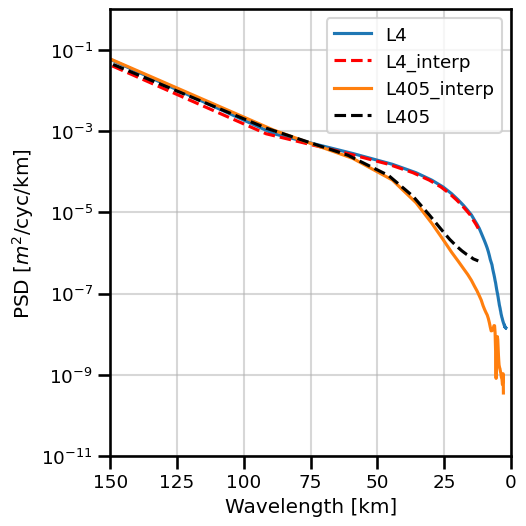

In [45]:


plt.rcParams["figure.figsize"] = [5.50, 5.50]


f, (ax1) = plt.subplots(1,1, sharey=True)



i='psd_analysed_sst'
mini1=np.where(L4[i]==L4[i].values.min())[0][0]
ax1.plot(1/L4[i]['freq_lon'+i[3:]][0:mini1]*111,L4[i][0:mini1], label='L4')

mini1=np.where(L4_interp[i]==L4_interp[i].values.min())[0][0]
ax1.plot(1/L4_interp[i]['freq_lon'+i[3:]][0:mini1]*111,L4[i][0:mini1], 'r--', label='L4_interp')

mini1=np.where(L405_interp[i]==L405_interp[i].values.min())[0][0]
ax1.plot(1/L405_interp[i]['freq_lon'+i[3:]][0:mini1]*111,L405_interp[i][0:mini1], label='L405_interp')

mini1=np.where(L405[i]==L405[i].values.min())[0][0]
ax1.plot(1/L405[i]['freq_lon'+i[3:]][0:mini1]*111,L405[i][0:mini1], 'k--',  label='L405')

ax1.set_ylabel('PSD [$m^2$/cyc/km]')
ax1.set_xlabel('Wavelength [km]')
ax1.grid(which="both", alpha=0.5)  
ax1.legend()
ax1.set_yscale('log')
ax1.set_xlim([0, 150])
ax1.invert_xaxis()
ymin, ymax = ax1.get_ylim()
ax1.set_ylim([0.00000000001, 1])

plt.tight_layout()
plt.show()    


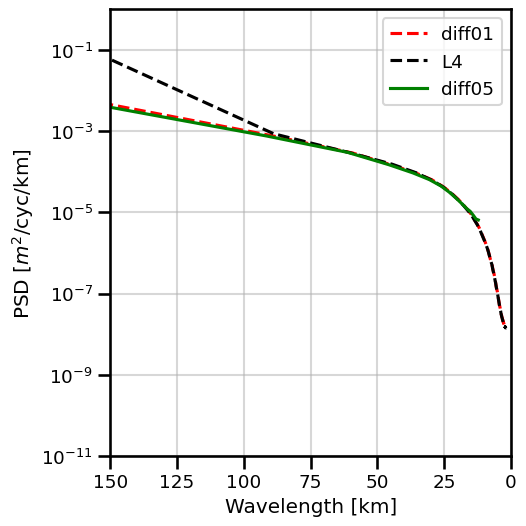

In [49]:


plt.rcParams["figure.figsize"] = [5.50, 5.50]


f, (ax1) = plt.subplots(1,1, sharey=True)





i='psd_analysed_sst'
mini1=np.where(diff01[i]==diff01[i].values.min())[0][0]
ax1.plot(1/diff01[i]['freq_lon'+i[3:]][0:mini1]*111,diff01[i][0:mini1], 'r--',label='diff01')

i='psd_analysed_sst'
mini1=np.where(L4[i]==L4[i].values.min())[0][0]
ax1.plot(1/L4[i]['freq_lon'+i[3:]][0:mini1]*111,L4[i][0:mini1], 'k--', label='L4')

i='psd_analysed_sst'
mini1=np.where(diff05[i]==diff05[i].values.min())[0][0]
ax1.plot(1/diff05[i]['freq_lon'+i[3:]][0:mini1]*111,diff05[i][0:mini1], 'g',label='diff05')
# mini1=np.where(L4_interp[i]==L4_interp[i].values.min())[0][0]
# ax1.plot(1/L4_interp[i]['freq_lon'+i[3:]][0:mini1]*111,L4[i][0:mini1], 'r--', label='L4_interp')

# mini1=np.where(L405_interp[i]==L405_interp[i].values.min())[0][0]
# ax1.plot(1/L405_interp[i]['freq_lon'+i[3:]][0:mini1]*111,L405_interp[i][0:mini1], label='L405_interp')

# mini1=np.where(L405[i]==L405[i].values.min())[0][0]
# ax1.plot(1/L405[i]['freq_lon'+i[3:]][0:mini1]*111,L405[i][0:mini1], 'k--',  label='L405')


ax1.set_ylabel('PSD [$m^2$/cyc/km]')
ax1.set_xlabel('Wavelength [km]')
ax1.grid(which="both", alpha=0.5)  
ax1.legend()
ax1.set_yscale('log')
ax1.set_xlim([0, 150])
ax1.invert_xaxis()
ymin, ymax = ax1.get_ylim()
ax1.set_ylim([0.00000000001, 1])

plt.tight_layout()
plt.show()    


## check cyclogeostrophy..


In [149]:
Upathlist = Path('/home/anas/MEOM_Workspace/data/raw/Daily2018').glob('*gridU-2D.nc')   
Upathlist=sorted(Upathlist)
Vpathlist = Path('/home/anas/MEOM_Workspace/data/raw/Daily2018').glob('*gridV-2D.nc')   
Vpathlist=sorted(Vpathlist)
i=10
U = xr.open_mfdataset(Upathlist[i])
V = xr.open_mfdataset(Vpathlist[i])


vitr=np.sqrt(U['un'][0]*U['un'][0]+V['vn'][0]*V['vn'][0])
vgeo=np.sqrt(U['ugeo'][0]*U['ugeo'][0]+V['vgeo'][0]*V['vgeo'][0])
vitr.attrs['long_name'] = 'cyclo'
vgeo.attrs['long_name'] = 'geo'


prs=100*(vitr-vgeo)/vgeo
prs.attrs['long_name'] = '100(viter-vgeo)/vgeo [%]'

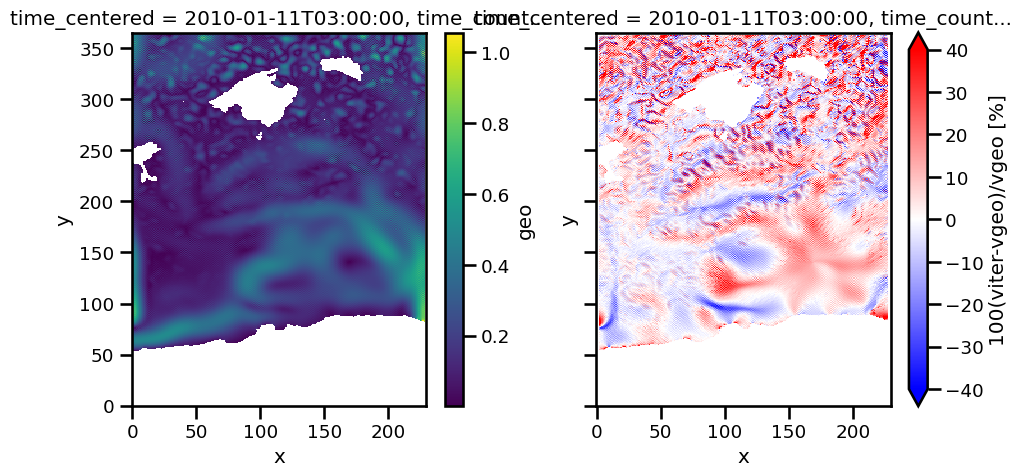

In [155]:


plt.rcParams["figure.figsize"] = [10, 5]
f, ax = plt.subplots(1, 2, sharey=True)

vgeo.plot(ax=ax[0])
prs.plot(ax=ax[1], vmin=-40, vmax=40, cmap='bwr')
plt.tight_layout()
plt.show()